# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [126]:
import numpy as np
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [122]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [123]:
class LinearRegression:
    _scores = None
    _params = {'l2_coef': None, 'learning_rate': None, 'n_iter': None}
    _weights = None
    _verbatim = False
    
    def __repr__(self):
        return f'<Linear Regressor with parameters alpha={self._params["l2_coef"]}, learning_rate={self._params["learning_rate"]}>'
    
    def __init__(self, alpha=0, learning_rate=0.01, n_iter=1000, verbatim=False):
        self._params['l2_coef'] = alpha
        self._params['learning_rate'] = learning_rate
        self._params['n_iter'] = n_iter
        self._verbatim = verbatim
        if self._verbatim:
            print(repr(self))
    
    def grad(self, X, y, w, alpha): 
        return (1./len(X)) * X.T @ (X @ w - y) + alpha * w
    
    def score(self, y_pred, y_true):
        return (1./len(y_pred)) * np.linalg.norm(y_pred - y_true) ** 2
    
    def fit(self, X, y):
        weights = np.random.rand(X.shape[1]).reshape(-1,1)
        scores = []
        m = X.shape[0]
        
        for step in range(self._params['n_iter']):
            weights = weights - self._params['learning_rate'] * self.grad(X, y, weights, self._params['l2_coef'])
            scores.append(self.score(X @ weights, y))
            if self._verbatim:
                print(scores[-1])
            
        self._weights = weights
        self._scores = scores
    
    def predict(self, X):
        return X @ self._weights

In [127]:
X = (X - np.mean(X)) / np.std(X)
Y = Y.reshape(-1, 1)

In [128]:
scores = []

for a in np.arange(0, 0.51, 0.01):
    linear_regressor = LinearRegression(alpha=a)
    linear_regressor.fit(X, Y)
    y_pred = X @ linear_regressor._weights
    scores.append(linear_regressor.score(y_pred, Y))

Text(0, 0.5, 'MSE')

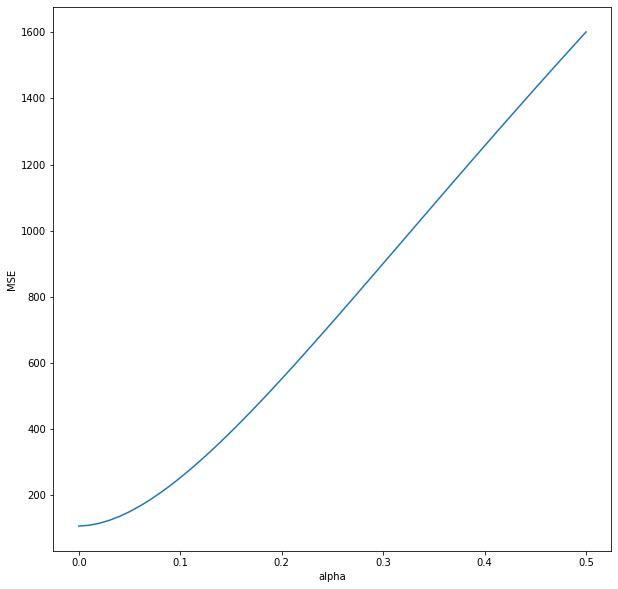

In [129]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.arange(0, 0.51, 0.01), scores)
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')

In [130]:
class GridSearchCV:
    _estimator = None
    _alpha_grid = None #Для простоты пусть будет только сетка для alpha
    _n_folds = None
    _best_estimator = None
    _best_alpha = None
    _scores = None
    
    def __init__(self, estimator, alpha_grid, n_folds=5):
        self._estimator = estimator
        self._alpha_grid = alpha_grid
        self._n_folds = 5
    
    def fit(self, X, y):
        num_samples = X.shape[0]
        num_test_samples = int(num_samples / self._n_folds)
        mean_scores = []
        estimators = [self._estimator(alpha=a) for a in self._alpha_grid]
        
        for estimator in estimators:
            fold_scores = []
            
            for fold_edge in range(num_test_samples, num_samples + num_test_samples, num_test_samples):
                X_train = np.vstack((X[:num_samples - fold_edge], X[num_samples + num_test_samples - fold_edge - 1]))
                y_train = np.vstack((y[:num_samples - fold_edge], y[num_samples + num_test_samples - fold_edge - 1]))
                X_test = X[num_samples - fold_edge : num_samples + num_test_samples - fold_edge - 1]
                y_test = y[num_samples - fold_edge : num_samples + num_test_samples - fold_edge - 1]
                  
                estimator.fit(X_train, y_train)
                y_pred = estimator.predict(X_test)
                fold_scores.append(estimator.score(y_pred, y_test))
            
            mean_scores.append(np.mean(fold_scores))
        
        self._best_estimator = estimators[np.argmin(mean_scores)]
        self._scores = mean_scores
        self._best_alpha = self._alpha_grid[np.argmin(mean_scores)]
        
    def plot_validation_curve(self):
        fig, ax = plt.subplots(figsize=(20,10))
        ax.plot(self._alpha_grid, self._scores)
        ax.set_xlabel('alpha')
        ax.set_ylabel('score')

In [132]:
gridCV = GridSearchCV(LinearRegression, alpha_grid=np.arange(0.01, 1.01, 0.01))
gridCV.fit(X, Y)

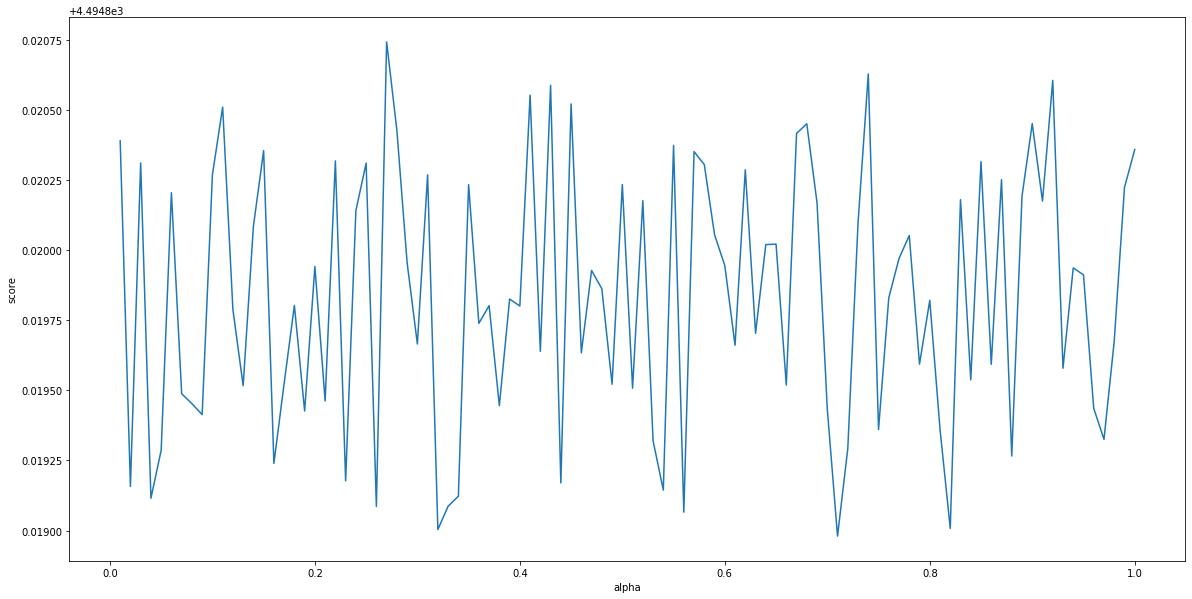

In [133]:
gridCV.plot_validation_curve()

In [134]:
training_scores = []
cv_scores = []

for step in range(100, 1100, 100):
    linreg = LinearRegression()
    linreg.fit(X[:step], Y[:step])
    training_scores.append(linreg._scores[-1])
    
    gridCV = GridSearchCV(LinearRegression, alpha_grid=np.arange(0.01, 0.51, 0.01))
    gridCV.fit(X[:step], Y[:step])
    cv_scores.append(min(gridCV._scores))


Text(0, 0.5, 'score')

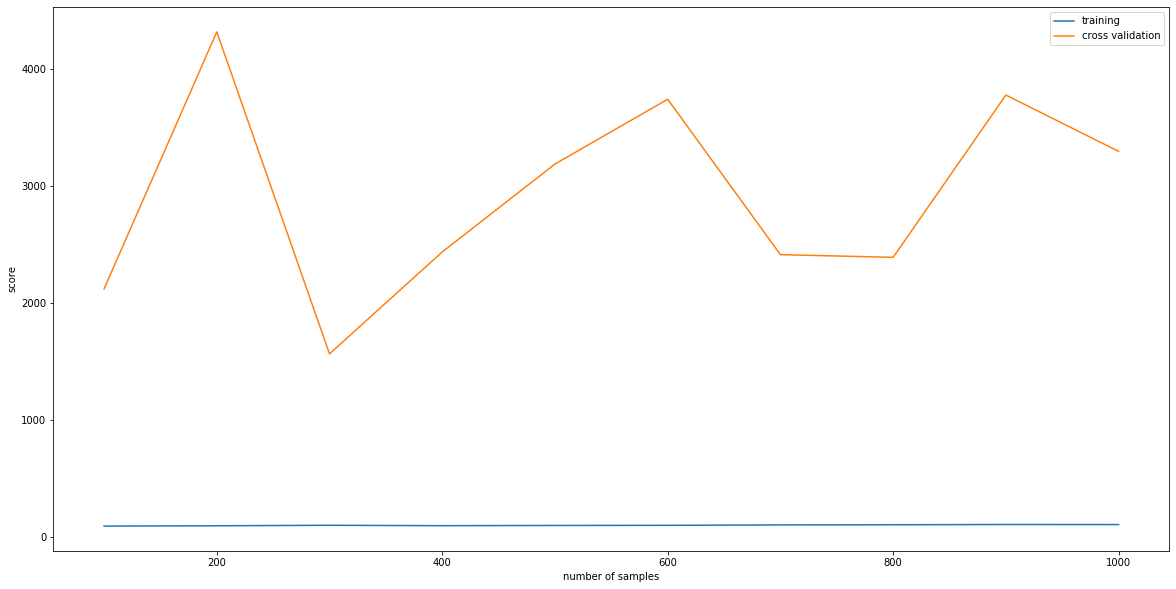

In [135]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(range(100, 1100, 100), training_scores)
ax.plot(range(100, 1100, 100), cv_scores)
ax.legend(['training', 'cross validation'])
ax.set_xlabel('number of samples')
ax.set_ylabel('score')